# Belief polarization in multi-agent active inference


In [ ]:
"""Uses pymdp module

A 'remix' of Tom Verguts' ch11_soc.py : 

    https://github.com/CogComNeuroSci/modeling-master/blob/master/code_by_chapter/Chapter_11/ch11_soc.py
    
Also an attempt to replicate this research:

    Albarracin, M., Demekas, D., Ramstead, M. J., & Heins, C. (2022). Epistemic communities under active inference. Entropy, 24(4), 476."""

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import networkx as nx
import seaborn as sns

from pymdp import utils
from pymdp.agent import Agent
from pymdp.maths import softmax

verbose = False

# Setting up the states

In [6]:
k_neighbours = 3

In [8]:
#hidden state factors

context_names = ['Idea 1', 'Idea 2']
ST = ['Null', 'Hashtag 1', 'Hashtag 2']
who = ['Null']+[f'Neighbour {k}' for k in range(1, 1 + k_neighbours)]
metabeliefs = [['Null', 'Believe H1', 'Believe H2'] for k in range(k_neighbours)]

hidden_states = [context_names, ST, who]+[metabeliefs[k] for k in range(k_neighbours)]
states_names = ["context_names", "ST", "who"]+[f"metabeliefs[{k}]" for k in range(k_neighbours)]
num_states = [len(i) for i in hidden_states]
num_factors = len(num_states)

In [9]:
#controls

context_control = ['Null']
ST_control = ['Null', 'Tweet Hashtag 1', 'Tweet Hashtag 2']
who_control = ['Null']+[f'Attend Neighbour {k}' for k in range(1, 1 + k_neighbours)]
mb_control = [['Null'] for k in range(k_neighbours)]

num_controls = [len(context_control), len(ST_control), len(who_control)]+[len(mb_control[k]) for k in range(k_neighbours)]


In [10]:
#outcome/observation modalities

ST_obs = ['Null', 'Tweet Hashtag 1', 'Tweet Hashtag 2']
who_obs = ['Null']+[f'Attend Neighbour {k}' for k in range(1, 1 + k_neighbours)]
ntweets_obs = [['Null', 'Believes H1', 'Believes H2'] for k in range(k_neighbours)]

outcomes = [ST_obs, who_obs]+[ntweets_obs[k] for k in range(k_neighbours)]
num_obs = [len(m) for m in outcomes]
num_modalities = len(num_obs)

# Setting the Generative Model

### Two little practical functions

In [11]:
#returns a tuple containing the number of states of each binding outcome + hidden_states

def A_structure(obs_mod, factors):
    ms = [len(obs_mod)]+[len(factors[j]) for j in range(len(factors))]
    t = tuple(i for i in ms)
    return t

In [13]:
"""This is a function that allows one to take a matrix such as a probabilistic relation between 
    the states of some hidden factor and an outcome modality, e.g identity matrix or bernoulli distribution
    between ST_obs and ST states, and allows it to fit into the highly dimensionnal A_m_shape-d matrix
    
    -- Otherwise you get an error message  like 'could not broadcast shape (3,3) into (2,3,3,3)'
    
    For example, we have 3 neighbours, and we want to fit an identity matrix between who_obs and who states 
    in the A_who_matrix. This way, agents can unambiguously know who they attend:
    
    list(who) and list(who_obs) will be 4 long so the identity matrix is shape (4,4).
    
    All A matrices have the structure outcome+hiddenstates, so here: [who_obs]+[context, ST, who, mb0, mb1, mb2]. 
    Using the A_structure function we get the length of all these states:(4,2,3,4,3,3,3). 
    So we can se here our (4,4) being separated in a crowd of 2's and 3's. We need some way 
    to fit our (4,4)-shaped identity matrix into a (4,2,3,4,3,3,3) matrix. This is what this function does.
    
    First, it expands the dimensions of the (4,4), adding new axes in the right place and with the right length, 
    i.e. from (4,4) into (4,x,x,4,x,x,x) (to get to the (4,2,3,4,3,3,3)). 
    
    Second, it tiles the matrix across all the new dimensions (ST,MBk...), since they are irrelevant to
    the ongoing relationship in the (4,4) matrix (who_obs - who), UNLESS we mention additionnal states in the 
    function arguments. If for some reason this matrix also depends on context, say for example that if 
    context is 1 it is an identity matrix, otherwise it's a randomn one, then when calling the function
    A_tuptile(who_obs, hidden_states, that_weird_matrix, "context", "who") then that weird matrix has to be 
    shape (4,2,4) when called. Otherwise, in A_tuptile(who_obs, hidden_states, matrix, "who") matrix has to be
    (4,4)"""

def A_tuptile(obs, #what modality are we talking about
            hsf, #what are the hidden state factors at play
            matrix, #what is the matrix we try to fit in our high dims - matrix : state * obs
            state, #what states are we considering
            additional_state1=None,
            additionnal_state2=None):

    a = list(A_structure(obs, hsf))

    a[0] = 1 # locating the modality

    if type(hsf[0]) == str: # use for smaller matrices manipulations with context ( /!\ cheating /!\)
        a = [1,2,1]
    else:
        state_idx = 1 + states_names.index(state) # locating the target state factor
        a[state_idx] = 1

    if additional_state1:
            additional_idx = 1 + states_names.index(additional_state1)
            a[additional_idx] = 1
    if additionnal_state2:
            additional_idx = 1 + states_names.index(additionnal_state2)
            a[additional_idx] = 1

    b = [i for i in range(-len(a), 0, 1)]
    new_b = []

    for i in range(len(a)):
        if a[i] != 1:  
            new_b.append(b[i])

    c = np.array(np.tile(np.expand_dims(matrix, tuple(new_b)), tuple(a))) #is the expanded matrix that fits the A[i] tensor

    return c

### A tensors

##### One for each outcome modality : ST_obs, who_obs, ntweet[k]

In [14]:
def A_GM(params):

    p_h = params['p_h'] #hashtag reliability parameter # the thought probability of behavior consistency i.e. how much does the agent trust the sampled behavior
    
    # define an entirely null-outcome matrix
    almost_not_h = np.swapaxes(np.array(

        [[[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0]],

        [[1, 1, 1],
         [0, 0, 0],
         [0, 0, 0]]]

    ), 0, 1) #structure was : outcome (3 rows) -> context (2 matrices) -> state (3 cols)
             #structure is : outcome (3 matrices) -> context (2 rows) -> state (3 cols)
    
    # define a Bernoulli-like matrix 
    mx = np.array(
        
        [[[1, 0, 0],
        [0, p_h, 1 - p_h],
        [0, 1 - p_h, p_h]],

        [[1, 0, 0],
        [0, 1-p_h, p_h],
        [0, p_h, 1-p_h]]]
    
    )

    # softmax the bernoulli part of the matrix
    for i in range(len(context_names)):
        b = softmax(params['gamma']*mx[i][1:,1:])
        mx[i][1:,1:] = b
        
    # and swapaxes 
    almost_h = np.swapaxes(mx, 0, 1) #structure was : outcome (3 rows) -> context (2 matrices) -> state (3 cols)
                                     #structure is : outcome (3 matrices) -> context (2 rows) -> state (3 cols)

    #print(almost_h.shape)
    #print(mx)

    A_m_shapes = [[obs_dim]+num_states for obs_dim in num_obs] # list of shapes of modality-specific A[m] arrays

    A = utils.obj_array_zeros(A_m_shapes)
    
    A_ST_obs = np.zeros(A_structure(ST_obs, hidden_states))
    A_ST_obs = A_tuptile(ST_obs, hidden_states, almost_h, "context_names", "ST")
    A[0] = A_ST_obs

    A_who_obs = np.zeros(A_structure(who_obs, hidden_states))
    A_who_obs = A_tuptile(who_obs, hidden_states, np.eye(len(who_obs)), "who") #Identity matrices - No ambiguity in observing a who
    A[1] = A_who_obs

    A_ntweet_obs = [0 for k in range(k_neighbours)]

    for k in range(k_neighbours):

        A_ntweet_obs[k] = np.zeros(A_structure(ntweets_obs[k], hidden_states))

        ntk = states_names.index(f'metabeliefs[{k}]')
        nbx = 1 + k
        idx = 1 + nbx  # to prevent overwriting the previous matrix A[1]
        neighbourhood = who[1:]

        #create an array of len neighbourhood, in which there are not_h matrices and only one h matrix (for the targeted neighbour)
        #the key is to be able to place the h matrix at right index so that when focal agent targets agent X then he gets agent X observation
        almost_big_h = np.array([almost_not_h]+[almost_h if j == k else almost_not_h for j in range(len(neighbourhood))])
        big_h = np.swapaxes(np.swapaxes(almost_big_h, 0, 1), 1, 2)
        # almost_big_h was in order "who-outcome-context-MBk" (shape k,3,2,3) but we needed order "outcome-context-who-MBk" (shape 3,2,k,3)to do the tuptile trick

        A_NTk_obs = A_tuptile(A_ntweet_obs[k], hidden_states, big_h, "context_names", "who", f"metabeliefs[{k}]") #tile big_h across the remaining dimnesions in hidden_states after we remove the "" variables
        A_ntweet_obs[k] = A_NTk_obs

        A[idx] = A_ntweet_obs[k]
    
    #Sanity Check
    #for i in range(len(A)):
        #print("A" + str(i), "| Normalized:", utils.is_normalized(A[i]), "| Shape fit:", list(A[i].shape) == A_m_shapes[i], "| Shape:", A[i].shape, "| Combinations:", np.prod(list(A[i].shape)))

    return A

## B Tensors

##### One for each control

In [15]:
def B_GM(params):
    
    B_f_shapes = [[ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]
    B = utils.obj_array_zeros(B_f_shapes)

    B_context = np.zeros(tuple(B_f_shapes[hidden_states.index(context_names)]))
    B_context[:, :, 0] = softmax(params['inv_env_volatility']*np.eye(len(context_names)))
    B[0] = B_context

    B_ST = np.zeros(tuple(B_f_shapes[hidden_states.index(ST)]))
    for ST_id in range(len(ST)):
        B_ST[ST_id, :, ST_id] = 1.0 # you can control your actions without ambiguity
    B[1] = B_ST

    B_who = np.zeros(tuple(B_f_shapes[hidden_states.index(who)]))
    for who_id in range(len(who)):
        B_who[who_id, :, who_id] = 1.0
    B[2] = B_who

    B_metabeliefs = [0 for k in range(k_neighbours)]
    for k in range(k_neighbours):
        idx = k + hidden_states.index(metabeliefs[k])  # to prevent overwriting the previous matrix A[1]
        B_metabeliefs[k] = np.zeros(tuple(B_f_shapes[states_names.index(f'metabeliefs[{k}]')]))
        B_metabeliefs[k][:, :, 0] = softmax(params['inv_soc_volatility']*np.eye(len(metabeliefs[k])))
        B[idx] = B_metabeliefs[k]
    
    #Sanity Check
    #for i in range(len(B)):
        #print("B" + str(i), "| Normalized:", utils.is_normalized(B[i]), "| Shape fit:", list(B[i].shape) == B_f_shapes[i],"| Shape:", B[i].shape)

    return B

## C Matrices

##### One per outcome modality

In [17]:
def C_GM(params):
    
    C = utils.obj_array_zeros(num_obs) # note: num_obs is a list, which is why we can use obj_array_zeros here

    C_ST = np.zeros(len(ST))
    C_ST[:] = params['ST_pref'] # ST1 vs ST2
    C[0] = C_ST  #C[1] can remain all zeros ######################## why?

    C_who = np.zeros(len(who))
    C[1] = C_who

    for k in range(k_neighbours):

        C_ntweets = np.zeros((k_neighbours, len(ntweets_obs[k])))
        
        idx = 2 + k
        C_ntweets[k] = params['NT_pref'] #Null, MB1, MB2

        C[idx] = C_ntweets[k]
        
    return C

## D Matrices

##### One per state factor

In [31]:
def D_GM(params):
    
    D = utils.obj_array(num_factors)

    D_context = params['Context_priors']
    D[0] = D_context

    D_ST = np.zeros(len(ST))
    D_ST[ST.index("Null")] = 1.0
    D[1] = D_ST

    D_who = np.zeros(len(who))
    D_who[who.index("Null")] = 1.0
    D[2] = D_who

    D_metabeliefs = [0 for k in range(k_neighbours)]
    for k in range(k_neighbours):
        idx = k + hidden_states.index(metabeliefs[k])
        D_metabeliefs[k] = np.zeros(len(metabeliefs[k]))
        D_metabeliefs[k][:] = 1/len(metabeliefs[k])
        D[idx] = D_metabeliefs[k]

    #Sanity Check
    #for i in range(len(D)):
        #print("D" + str(i), "| Normalized:", utils.is_normalized(D[i]), "| Shape:", D[i].shape)

    return D

# Generative Process

In [32]:
class Knowthyself(object):
    
    def __init__(self,
                 context=None,
                 p_ST_GP=0.8,  # how often does the sample action actually return the correct behavior
                 p_NT_GP=0.8,  # how often does the call action actually return the correct hint
                 prob_idea=[0.5, 0.5]
                ):

        self.context_names = context_names
        self.prob_idea = prob_idea

        if context is None:
            self.context = self.context_names[
                utils.sample(np.array(self.prob_idea))]  # randomly sample which trait you have (Idea1 or Idea2)
        else:
            self.context = context

        self.p_ST_GP = p_ST_GP
        self.p_NT_GP = p_NT_GP

        self.ST_obs = ST_obs
        self.who_obs = who_obs
        self.k_neighbours = k_neighbours
        self.metabeliefs = metabeliefs
        self.ntweets_obs = ntweets_obs

    def tweet(self, action):

        if action == "Start":
            observed_ST = "Null"

        elif action == "Tweet Hashtag 1":
            if self.context == "Idea 1":
                observed_ST = self.ST_obs[utils.sample(np.array([0.0, self.p_ST_GP, 1 - self.p_ST_GP]))]
            if self.context == "Idea 2":
                observed_ST = self.ST_obs[utils.sample(np.array([0.0, 1 - self.p_ST_GP, self.p_ST_GP]))]

        elif action == "Tweet Hashtag 2":
            if self.context == "Idea 1":
                observed_ST = self.ST_obs[utils.sample(np.array([0.0, 1 - self.p_ST_GP, self.p_ST_GP]))]
            if self.context == "Idea 2":
                observed_ST = self.ST_obs[utils.sample(np.array([0.0, self.p_ST_GP, 1 - self.p_ST_GP]))]

        obs = [observed_ST]

        return obs

    def attendence(self, action):
        return [action]

    def attendence_with_spice(self, action):

        # we want something like [Attend Neighbour 2, Null, Believes X, Null, Null, ...]
        obs = np.zeros(len(who_obs))
        obs = [who[0]] + [np.tile(['Null'], k_neighbours)]

        if action == 'Null':
            return obs

        elif action != 'Null':

            nbx = who_control.index(action)
            idx = 1 + nbx # place in obs list

            obs[0] = who_obs[nbx]

            if self.context == "Idea 1":
                obs[nbx] = self.ntweets_obs[nbx][utils.sample(np.array([0.0, 1 - self.p_NT_GP, self.p_NT_GP]))]
            if self.context == "Idea 2":
                obs[nbx] = self.ntweets_obs[nbx][utils.sample(np.array([0.0, self.p_NT_GP, 1 - self.p_NT_GP]))]

        return obs

# Active inference

In [33]:
def entropy(q):
    ent = np.ndarray(num_factors)
    for loop in range(num_factors):
        ent[loop] = -np.dot(q[loop], np.log(q[loop]))
    return ent

In [40]:
def run_active_inference_loop(my_env, T=5):

    #Initialize the first observation
    initial_null = np.tile(["Null"], (len(agents), len(outcomes)))
    #initial_obs = np.tile(initial_null, (len(agents), 1))  # observation 0 for ST, who, NT1, NT2

    obs = [[outcomes[i].index(initial_null[j][i]) for i in range(len(initial_null[0]))] for j in range(len(agents))]
    #return 4 arrays of length 4 filled with 0 (corresponding to Null in each modality)
    #print(obs)

    everybodys_partials = []  # partial observation labels for each time step and each agent own actions (i.e ST_obs and who_obs)
    obs_label_history = []
    obs_label_history.append(initial_null)
    
    obs_history = np.zeros((T+1, len(agents), num_modalities))
    obs_history[0] = obs

    ent = np.zeros((T, num_factors, len(agents)))
    belief_context = np.zeros((T, len(context_names), len(agents)))
    belief_tweet = np.zeros((T, len(ST_obs), len(agents)))
    belief_who = np.zeros((T, len(who_obs), len(agents)))

    for t in range(T):

        everybodys_partials.append([])

        for agent_id, agent in enumerate(agents):

            # inference
            qs = agent.infer_states(list(obs[agent_id]))
            q_pi, G = agent.infer_policies()
            chosen_action_id = agent.sample_action()

            # entropy & stuff
            ent[t, :, agent_id] = entropy(qs)
            belief_context[t,:,agent_id] = qs[0]
            belief_tweet[t, :, agent_id] = qs[1]
            belief_who[t, :, agent_id] = qs[2]
            
            # controls
            ST_id = int(chosen_action_id[1])
            who_id = int(chosen_action_id[2])
            choice_ST = ST_control[ST_id]
            choice_who = who_control[who_id]

            # First half of observations (without neighbour tweet yet):
            partial_obs_label = my_env.tweet(choice_ST) + my_env.attendence(choice_who)  # e.g [Hashtag 2, Attend Neighbour 1]

            # appends
            everybodys_partials[t].append(partial_obs_label)

        # to the first half we add the other one, of length k_neighbours , and we fill it with Null for now
        full_obs_label = [everybodys_partials[t][agent_id] + list(np.tile(["Null"], len(agents) - 1)) for agent_id, _ in
                          enumerate(agents)]  # e.g [Hashtag 2, Attend Neighbour 1, Null, Null]

                                    # full_obs_label structure : n_agents * n_outcomes

        # now sharing the information between agents
        for agent_id, agent in enumerate(agents):
            neighbours = agents[:]                              # make a copy of agents list
            neighbours.remove(agent)                            # remove the actual agent from it / agent0 nb's: agent 1&2; agent1 nb's: agent 0&2; agent 2 nb's: 0&1
            attendence = full_obs_label[agent_id][1]            # consult the resulting agent from choice_who control
            if attendence != "Null":                            # if agent is attending a neighbour... but which neighbour:
                nbx = who_obs[1:].index(attendence)             # 0 for neighbour 1, 1 for neighbour 2 ...
                idx = 2 + nbx                                   # because we'll overwrite in the NT_obs part of the outcome label (that was filled with Nulls), which happen to start at index 2 (cfr full_obs structure)
                full_obs_label[agent_id][idx] = ntweets_obs[nbx][ST_obs.index(everybodys_partials[t][agents.index(neighbours[nbx])][0])]
                                                                #translating self tweets into neighbour tweets observations

        # full outcome observation label for each agent
        obs = [[outcomes[i].index(full_obs_label[j][i]) for i in range(len(full_obs_label[0]))] for j in range(len(agents))]
        obs_history[t+1] = obs
        #print("Step", t)
        #print("obs labels :", full_obs_label)
        #print("obs codes :", obs)

        obs_label_history.append(full_obs_label)

    return ent, belief_context, belief_tweet, belief_who, obs_label_history, obs_history



# Plotting functions

In [41]:
def plot_entropy(entr, belief_context):  # might make a nested functions entropy first, and plot entropy second

    subp = 2
    fig, axs = plt.subplots(1, subp, figsize = (12.8, 4.6))
                            
    for agent_id, agent in enumerate(agents):
        axs[0].plot(range(T), entr[:, 0, agent_id], marker='o')
        axs[1].plot(range(T), belief_context[:, 0, agent_id], marker='o', linestyle='-', linewidth=1)
        
    axs[0].legend(agents_names)
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Entropy")
    axs[0].set_title(f'Idea Entropy in agents')
                 
        
    axs[1].legend(agents_names, loc=1)
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Idea 1 Belief")
    axs[1].set_title(f'Beliefs in Idea 1')
    
    for i in range(subp):
        axs[i].set_xticks(np.arange(0, T, 10))
        axs[i].set_yticks(np.arange(0, 1, 0.1))
        axs[i].grid(True, which='major', linestyle='--', linewidth=0.2)
        axs[i].spines["right"].set_visible(True)
        axs[i].spines["top"].set_visible(True)
        axs[i].set_ylim([0, 1.05])  
            
    plt.show()
    
def other_entropy(entr):  # shows entropy in ST and who states, which are always 0 since they are encoded as Id matrices in the generative model

    fig, axs = plt.subplots(1, 2, figsize = (12.8, 4.6))
                            
    for agent_id, agent in enumerate(agents):
        axs[0].plot(range(T), entr[:, 1, agent_id], marker='o')
        axs[1].plot(range(T), entr[:, 2, agent_id], marker='o', linestyle='-', linewidth=1)
        
    axs[0].legend(agents_names)

    axs[0].spines["right"].set_visible(True)
    axs[0].spines["top"].set_visible(True)
    axs[0].set_xlabel("Time")
    axs[0].set_xticks(np.arange(0, T, 10))
    axs[0].set_ylabel("Entropy")
    axs[0].set_yticks(np.arange(0, 1, 0.1))
    axs[0].set_ylim([0, 1])

    axs[0].grid(True, which='major', linestyle='--', linewidth=0.2)
    axs[0].set_title(f'ST Entropy in agents')
                 
        
    axs[1].legend(agents_names)

    axs[1].spines["right"].set_visible(True)
    axs[1].spines["top"].set_visible(True)
    axs[1].set_xlabel("Time")
    axs[1].set_xticks(np.arange(0, T, 10))
    axs[1].set_yticks(np.arange(0, 1, 0.1))
    axs[1].set_ylim([0, 1.1])
    axs[1].grid(True, which='major', linestyle='--', linewidth=0.2)

    axs[1].set_title(f'Who Entropy in agents')

    plt.show()

def plot_belief_history(belief_context):
    # plot stacked bars
    fig, axs = plt.subplots(1, len(agents), figsize=(20, 5))

    for agent_id, agent in enumerate(agents):
        axs[agent_id].bar(range(T), belief_context[:, 0, agent_id], color='teal')
        axs[agent_id].bar(range(T), belief_context[:, 1, agent_id], bottom=belief_context[:, 0, agent_id], color='orange')
        axs[agent_id].set_title(f'Agent {agent_id} belief change')
        axs[agent_id].legend(["Idea 1", "Idea 2"], loc=1)
    
        axs[agent_id].spines["right"].set_visible(True)
        axs[agent_id].spines["top"].set_visible(True)
        axs[agent_id].set_xlabel("Time")
        axs[agent_id].set_xticks(np.arange(0, T, 10))
        axs[agent_id].set_yticks(np.arange(0, 1.01, 0.5))
        axs[agent_id].set_ylim([0, 1.1])
    plt.show()
    
def plot_belief_cdecay(belief_context):
    # plot stacked bars
    fig, axs = plt.subplots(1, len(agents), figsize=(20, 5))

    for agent_id, agent in enumerate(agents):
        for t in range(T):
            axs[agent_id].bar(t, 0.5, 
                              alpha = float(belief_context[t, 0, agent_id]), 
                              color='teal', 
                              edgecolor = 'teal',
                              width=1)
            
            axs[agent_id].bar(t, 0.5, 
                              alpha = float(belief_context[t, 1, agent_id]), 
                              bottom=0.5, 
                              color='orange', 
                              edgecolor = 'orange',
                              width=1)
            
        axs[agent_id].set_title(f'Agent {agent_id} belief change')
        axs[agent_id].legend(["Idea 1", "Idea 2"], loc=1)

        axs[agent_id].spines["right"].set_visible(True)
        axs[agent_id].spines["top"].set_visible(True)
        axs[agent_id].set_xlabel("Time")
        axs[agent_id].set_xticks(np.arange(0, T, 10))
        axs[agent_id].set_yticks(np.arange(0, 1.01, 0.5))
        axs[agent_id].set_ylim([0, 1.1])
        
plt.show()

def plot_tweet_history(obs_history):
    # plot stacked bars
    fig, ax = plt.subplots(figsize=(16, 4.6))
    colors = px.colors.qualitative.T10
    colors = ['c', 'teal', 'orange']

    for agent_id, agent in enumerate(agents):
        #for k in range(len(ST_obs)):
            #ax.bar(range(T), belief_tweet[:, k, agent_id].round(2), color=colors[k],bottom = agent_id - 0.5, width = 1,edgecolor = 'k', zorder = 2)
        for t in range(T):            
            o = int(obs_history[t, agent_id, 0])
            ax.bar(t, 1, color=colors[o],bottom = agent_id - 0.5, width = 1,edgecolor = 'k', zorder = 2)

    ax.spines["right"].set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.set_xlabel("Time")
    ax.set_ylabel("Agents")
    ax.set_xticks(np.arange(0, T, 10))
    ax.set_yticks(np.arange(0, len(agents), 1.0))
    ax.set_ylim([-0.5, len(agents)-0.5])
    ax.grid(True, which='major', linestyle='-', linewidth=1, zorder = 1)
    ax.set_title(f'Agents tweets', fontsize = 30)
    ax.legend(["Null", "Tweet 1", "Tweet 2"], loc=1)
    leg = ax.get_legend()
    for k in range(len(ST_obs)):
        leg.legendHandles[k].set_color(colors[k])
    plt.show()

def who_to_who(obs_history):
    #Need to transform the who obs into an actual agent name from the canonical list 
    #Input: every agent's who_obs observations at each timestep (w)
    #Output: who that points to among all the agents
    #the problem being that agents observations count alwayhs on a list of agents from which the actual agent is removed, so we need to refix this
    
    who_obs_history = obs_history[:,:,1] # outcome modality = Who obs (index 1)
    who_who = who_obs_history
    
    wr = np.zeros((T+1, len(agents)))
    
    for agent_id, agent in enumerate(agents_names):
        
        w = who_who[:, agent_id]
        nbx = agents_names[:]        
        nbz = agents_names[:]
        nbx.remove(agent)

        for t in range(T+1):
            if int(w[t]) == 0:
                wr[t][agent_id] = 0           
            else: 
                wr[t][agent_id] = 1 + nbz.index(nbx[int(w[t])-1]) # ... 
            
    return wr 

def plot_who_attended_who(obs_history):
    # plot stacked bars
    fig, ax = plt.subplots(figsize=(20, 4.6))
    colors = px.colors.qualitative.T10
    
    for agent_id, agent in enumerate(agents):
        for t in range(T):
            o = int(who_to_who(obs_history)[t, agent_id])
            ax.bar(t, 1, color=colors[o],bottom = agent_id - 0.5, width = 1, edgecolor = 'k', zorder = 2)

    ax.spines["right"].set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.set_xlabel("Time")
    ax.set_ylabel("Agents")
    ax.set_xticks(np.arange(0, T, 10))
    ax.set_yticks(np.arange(0, len(agents), 1.0))
    ax.set_ylim([-0.5, len(agents)-0.5])
    ax.set_title(f'Who attended who?', fontsize = 30)
    legendz = ["Null"] + agents_names
    ax.legend(legendz, loc=1, prop={'size':10})
    leg = ax.get_legend()    
    for k in range(len(legendz)):
        leg.legendHandles[k].set_color(colors[k])

    ax.grid(True, which='major', linestyle='-', linewidth=1.5, zorder = 1)

    plt.show()

def agent_cube(belief_context):
    
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot(projection='3d')

    colors = px.colors.qualitative.T10[:len(agents)]
    yticks = [agent_id for agent_id, agent in enumerate(agents)]

    for c, k in zip(colors, yticks):
        # Generate the random data for the y=k 'layer'.
        xs = range(T)
        ys_Idea1 = belief_context[:, 0, k]
        ys_Idea2 = belief_context[:, 1, k]

        # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
        ax.bar(xs, ys_Idea1, zs=k, zdir='y', color=colors[k], alpha=0.5)
        #ax.bar(xs, ys_Idea2, zs=k, zdir='y', color=colors[0], alpha=0.5, bottom = ys_Idea1)


    ax.set_xlabel('Time')
    ax.set_ylabel('Agents')
    ax.set_zlabel('Beliefs')

    # On the y axis let's only label the discrete values that we have data for.
    ax.set_yticks(yticks)
    ax.set_title(f"Agents Beliefs in Idea 1", fontsize = 30)

    ax.legend(agents_names, loc = 'upper left')

    plt.show()

#######################################################################################################    


# Data extraction & Heatmap Functions

In [42]:
def count_attendences(obs_history):
    global_attendences = dict((agents_names[i], 0) for i in range(len(agents_names)))
    for agent_id, agent in enumerate(agents_names):
        agc = agents_names[:]
        agc.remove(agent)
        full_agc = ["Null"] + agents_names[:]
        keys = ["Null"] + agc
        agent_attd = who_to_who(obs_history)[:, agent_id]

        attendences = dict((keys[i], 0) for i in range(len(keys)))
        for i in range(len(agent_attd)):
            w = int(agent_attd[i])
            attendences[full_agc[w]] += 1
        global_attendences[agent] = attendences

    return global_attendences


def plot_weighted_graph(obs_history):

    colors = px.colors.qualitative.T10
    
    #nodes
    G = nx.DiGraph() #Create a graph object called G
    agentz = agents_names[:]
    node_list = ["Null"] + agentz
    
    for node in node_list:
        G.add_node(node)
        
    #can also try nx.spring_layout(G)
    pos=nx.circular_layout(G)
    plt.figure(3,figsize=(20,20)) 
    
    for a in node_list:
        nx.draw_networkx_nodes(G, pos, nodelist = [a],
                               node_color=colors[node_list.index(a)],node_size=9000, margins = 0.1)     
    for i in agentz:
        nody = node_list[:]
        nody.remove(i)
        #print(nody)
        for j in nody:
            G.add_edge(i, j, edge_color = colors[node_list.index(j)], weight = count_attendences(obs_history)[i][j])
    
    all_weights = []
    all_colors = []
    # Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness
        all_colors.append(data['edge_color'])
    
    #print(all_weights)
    h = nx.draw_networkx_edges(G,pos,connectionstyle='arc3, rad = 0.05',
                               edgelist=G.edges(),width=all_weights, 
                               edge_color = all_colors)
        
    nx.draw_networkx_labels(G,pos,font_size=15,font_family='sans-serif')

    plt.axis('off')
    plt.title('Who is being attended the most?', fontsize = 30)
    
    def make_proxy(clr, mappable, **kwargs):
        return Line2D([0, 1], [0, 1], color=clr, **kwargs)
    
    colorz = colors[:len(node_list)]
    proxies = [make_proxy(color, set(h), lw=5) for color in colorz]
    labels = [f"Attends {i}" for i in node_list]
    plt.legend(proxies, labels, prop={'size': 15})
    plt.show() 
    
def polarisation_index(ndata, g_val, is_val, sim = None):
    #ndata structure is: [g_val, is_val, sim, RAIL output]
    roz = []  
    for s in range(S):
        bb = ndata[g_val,is_val,s,1][-1,0,:] 
        rho = np.max(bb) - np.min(bb)
        if sim & s == sim:
            return rho
    µ_rho = np.mean(roz)
        
    return µ_rho

def polarisation_index_better(ndata):
    #ndata structure is: [g_val, is_val, sim, RAIL output]
    pi = np.zeros((len(gamma_values), len(inv_soc_values)))
    vpi = np.zeros((len(gamma_values), len(inv_soc_values)))
    
    for g in range(len(gamma_values)):
        for i in range(len(inv_soc_values)):
            roz = []           
            for s in range(S):
                bb = ndata[g,i,s,1][-1,0,:] 
                rho = np.max(bb) - np.min(bb)
                roz.append(rho)
                
            µ_roz = np.mean(roz)
            v_roz = np.var(roz)
            
            pi[g,i] = µ_roz
            vpi[g,i] = v_roz
            
    return pi, vpi

# RE-ATTENDENCE RATE

def NestedDictValues(d):
  for v in d.values():
    if isinstance(v, dict):
      yield from NestedDictValues(v)
    else:
      yield v  
    
def reattendence_rate(obs_history):        
    l = list(NestedDictValues(count_attendences(obs_history)))
    rl = np.reshape(l, (len(agents),len(agents))) # agent -> observed attendence 
    rs = [np.max(rl[i]) for i in range(len(agents))]  
    µ_rs = np.meann(rs)
    return µ_rs

def reattendence_rate_better(ndata):
    
    ra = np.zeros((len(gamma_values), len(inv_soc_values)))
    vra = np.zeros((len(gamma_values), len(inv_soc_values)))
    
    for g in range(len(gamma_values)):
        for i in range(len(inv_soc_values)):
            raz = []           
            for s in range(S):    
                l = list(NestedDictValues(count_attendences(ndata[g,i,s,5]))) # 5 because of index in RAIL output tuple
                rl = np.reshape(l, (len(agents), len(agents))) # agent -> observed attendence 
                rs = [np.max(rl[i]) for i in range(len(agents))]
                µ_rs = np.mean(rs)
                raz.append(µ_rs)  
                
            µ_raz = np.mean(raz)
            v_raz = np.var(raz)
            
            ra[g,i] = µ_raz
            vra[g,i] = v_raz
    
    return ra, vra


def plot_heatmap(ndata):
    
    fig, ax = plt.subplots(2, 2, figsize = (20,16))
    
    dt1 = polarisation_index_better(ndata)[0]
    dt2 = reattendence_rate_better(ndata)[0]
    
    dt3 = polarisation_index_better(ndata)[1]
    dt4 = reattendence_rate_better(ndata)[1]
    
    im1 = sns.heatmap(dt1, linewidths= 0.5, cmap = 'crest', ax = ax[0,0])
    im2 = sns.heatmap(dt2, linewidths= 0.5, cmap = 'crest', ax = ax[0,1])
    
    im3 =  sns.heatmap(dt3, linewidths= 0.5, cmap = 'YlOrRd', ax = ax[1,0])
    im4 =  sns.heatmap(dt4, linewidths= 0.5, cmap = 'YlOrRd', ax = ax[1,1])
    
    ax[0,0].set_xticklabels(inv_soc_values)
    ax[0,0].set_yticklabels(gamma_values)
    ax[0,0].set_xlabel("Inverse social volatility", fontsize = 15)
    ax[0,0].set_ylabel("ECB levels", fontsize = 15)
    ax[0,0].set_title("Polarization index", fontsize = 20)
    
    ax[0,1].set_xticklabels(inv_soc_values)
    ax[0,1].set_yticklabels(gamma_values)
    ax[0,1].set_xlabel("Inverse social volatility", fontsize = 15)
    ax[0,1].set_ylabel("ECB levels", fontsize = 15)
    ax[0,1].set_title("Reattendence rate", fontsize = 20)

    ax[1,0].set_xticklabels(inv_soc_values)
    ax[1,0].set_yticklabels(gamma_values)
    ax[1,0].set_xlabel("Inverse social volatility", fontsize = 15)
    ax[1,0].set_ylabel("ECB levels", fontsize = 15)
    ax[1,0].set_title("Polarization index variance", fontsize = 20)
    
    ax[1,1].set_xticklabels(inv_soc_values)
    ax[1,1].set_yticklabels(gamma_values)
    ax[1,1].set_xlabel("Inverse social volatility", fontsize = 15)
    ax[1,1].set_ylabel("ECB levels", fontsize = 15)
    ax[1,1].set_title("Reattendence rate variance", fontsize = 20)
    
    return fig

def plot_performance_better(ndata, g_val, is_val, sim): # max g_vals and is_vals are given by the linspace parametrization
    plot_entropy(ndata[g_val,is_val,sim,0], ndata[g_val,is_val,sim,1])
    other_entropy(ndata[g_val,is_val,sim,0])
    agent_cube(ndata[g_val,is_val,sim,1])

    plot_belief_history(ndata[g_val,is_val,sim,1])
    plot_belief_cdecay(ndata[g_val,is_val,sim,1])
    plot_tweet_history(ndata[g_val,is_val,sim,5]) 
    plot_who_attended_who(ndata[g_val,is_val,sim,5])
    plot_weighted_graph(ndata[g_val,is_val,sim,5])

# Simple Simulation

In [46]:
%%time
# Plots without multisimulation implementation
params = {
    'gamma': 1,
    'p_h': 0.73,
    'inv_soc_volatility': 0.4,
    'inv_env_volatility': 6,
    'ST_pref': np.array([0,0,0]),
    'NT_pref': np.array([0,0,0]),
    'Context_priors' : np.array([0.5, 0.5])}

agents = [Agent(A=A_GM(params), B=B_GM(params), C=C_GM(params), D=D_GM(params)) for k in range(0, k_neighbours + 1)]   
agents_names = [f"Agent {a}" for a in range(len(agents))]                                                              
T = 30 #timesteps in simulation
env = Knowthyself(context = "Idea 2", p_NT_GP= 0.8)
entr, belief_context, belief_tweet, belief_who, obs_label_history, obs_history = run_active_inference_loop(env, T=T)

CPU times: total: 9.06 s
Wall time: 9.49 s


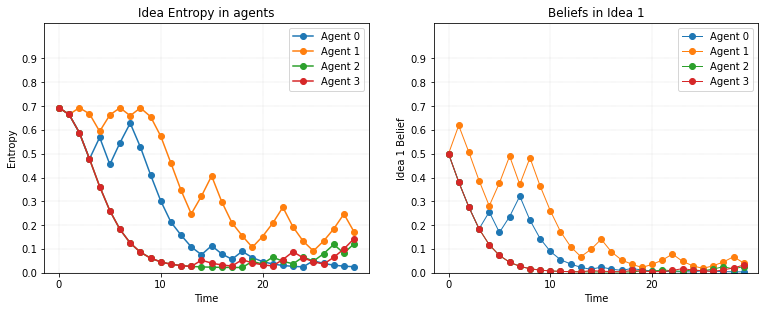

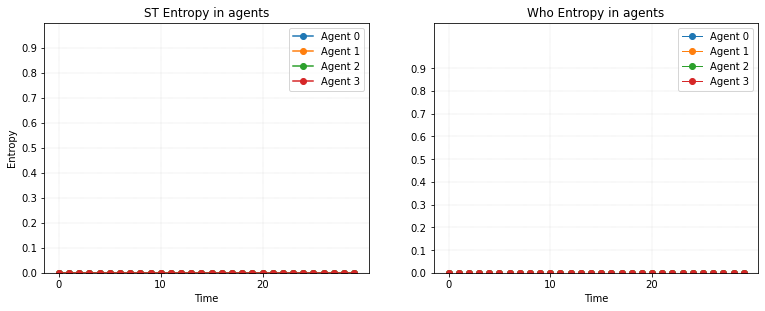

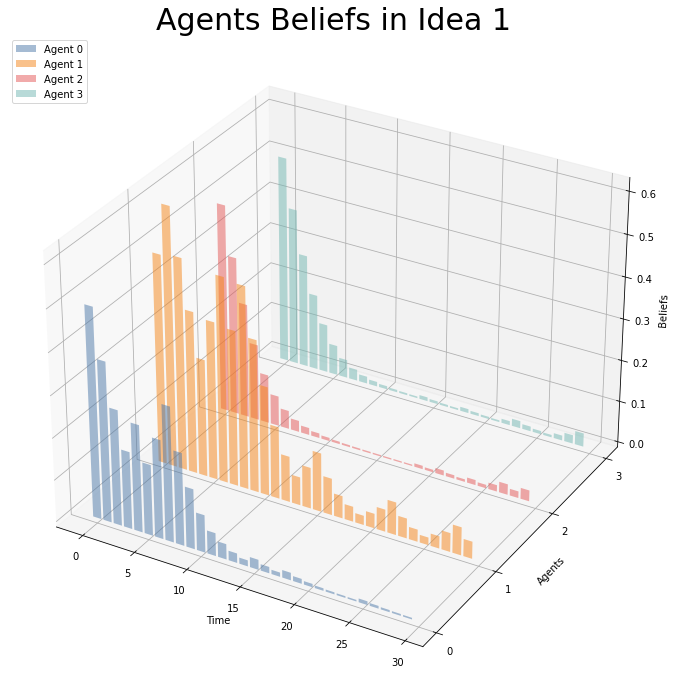

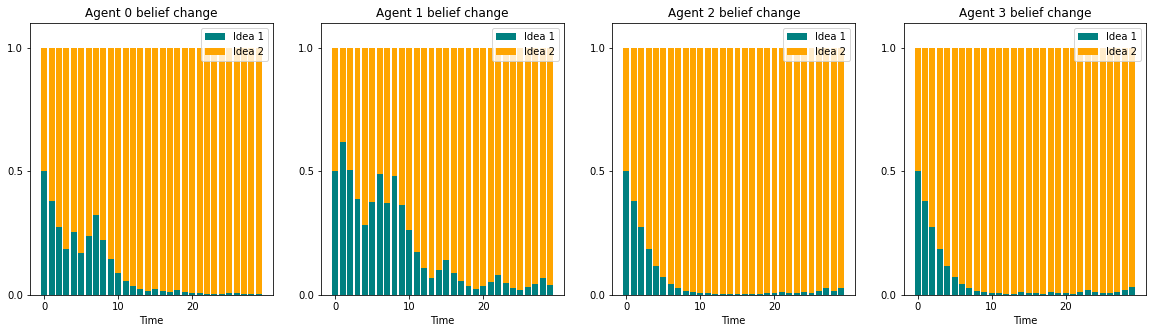

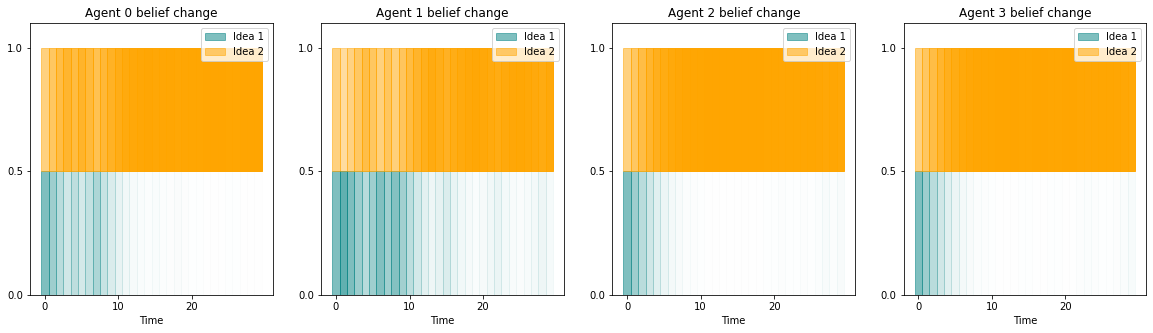

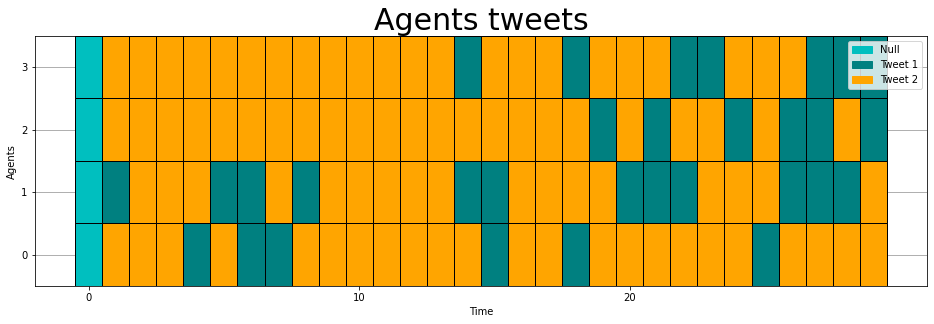

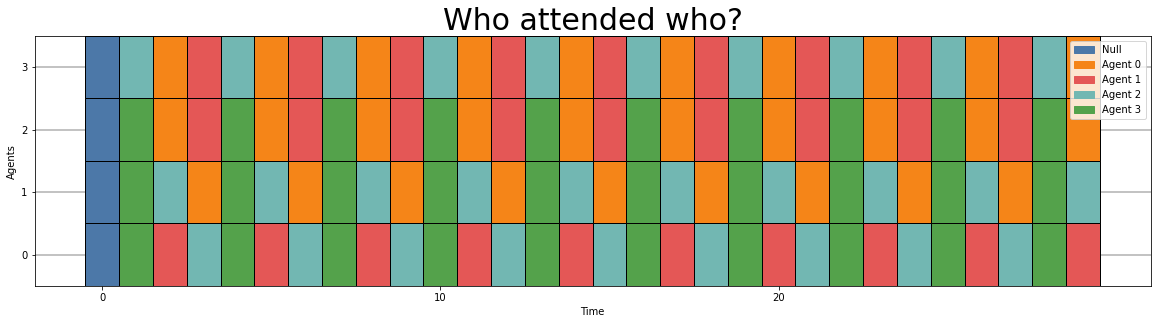

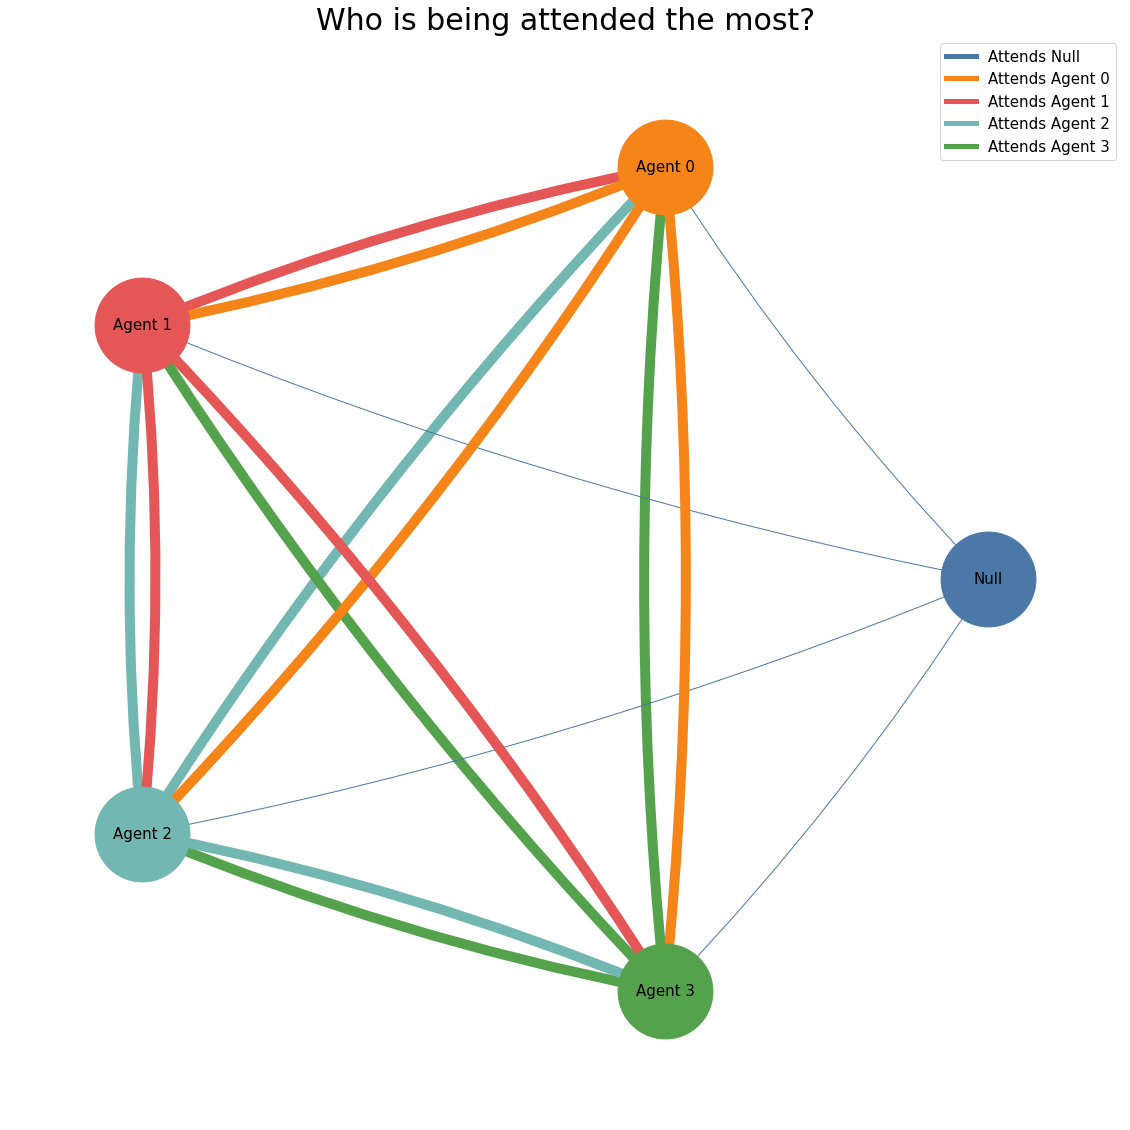

In [47]:
plot_entropy(entr, belief_context)
other_entropy(entr)

#these three basically show the same things, with varying degrees of fanciness
agent_cube(belief_context)
plot_belief_history(belief_context)
plot_belief_cdecay(belief_context)

#
plot_tweet_history(obs_history)

#these two show the same thing but the second is spicier
plot_who_attended_who(obs_history)
plot_weighted_graph(obs_history)

# Multi-Simulations

In [199]:
%%time
agents_names = [f"Agent {a}" for a in range(k_neighbours + 1)]                                                              

S = 7 #number of simulations
T = 30 #timesteps in simulation
env = Knowthyself(context = "Idea 2", p_NT_GP= 0.73)

gamma_values = list(np.linspace(0.05, 9.0, 15).round(2))
inv_soc_values = list(np.linspace(0.05, 9.0, 15).round(2))

ndata = np.zeros((len(gamma_values), len(inv_soc_values), S, 6), dtype = object) 
# g_vals, invsoc_vals, simulation, RAIL returned tuple length
for g in gamma_values:
    for i in inv_soc_values:
        for s in range(S):
            params = {
                        'gamma': g,
                        'p_h': 0.73,
                        'inv_soc_volatility': i,
                        'inv_env_volatility': 6,
                        'ST_pref': np.array([0,0,0]),
                        'NT_pref': np.array([0,0,0]),
                        'Context_priors' : np.array([1, 0])}

            agents = [Agent(A=A_GM(params), B=B_GM(params), C=C_GM(params), D=D_GM(params)) for k in range(0, k_neighbours + 1)]   
            entr, belief_context, belief_tweet, belief_who, obs_label_history, obs_history = run_active_inference_loop(env, T=T)
            cc = entr, belief_context, belief_tweet, belief_who, obs_label_history, obs_history
            ndata[gamma_values.index(g), inv_soc_values.index(i), s, :] = cc
            agents = [Agent(A=A_GM(params), B=B_GM(params), C=C_GM(params), D=D_GM(params)) for k in range(0, k_neighbours + 1)] #reset agents  



CPU times: total: 2h 45min 5s
Wall time: 2h 50min 23s


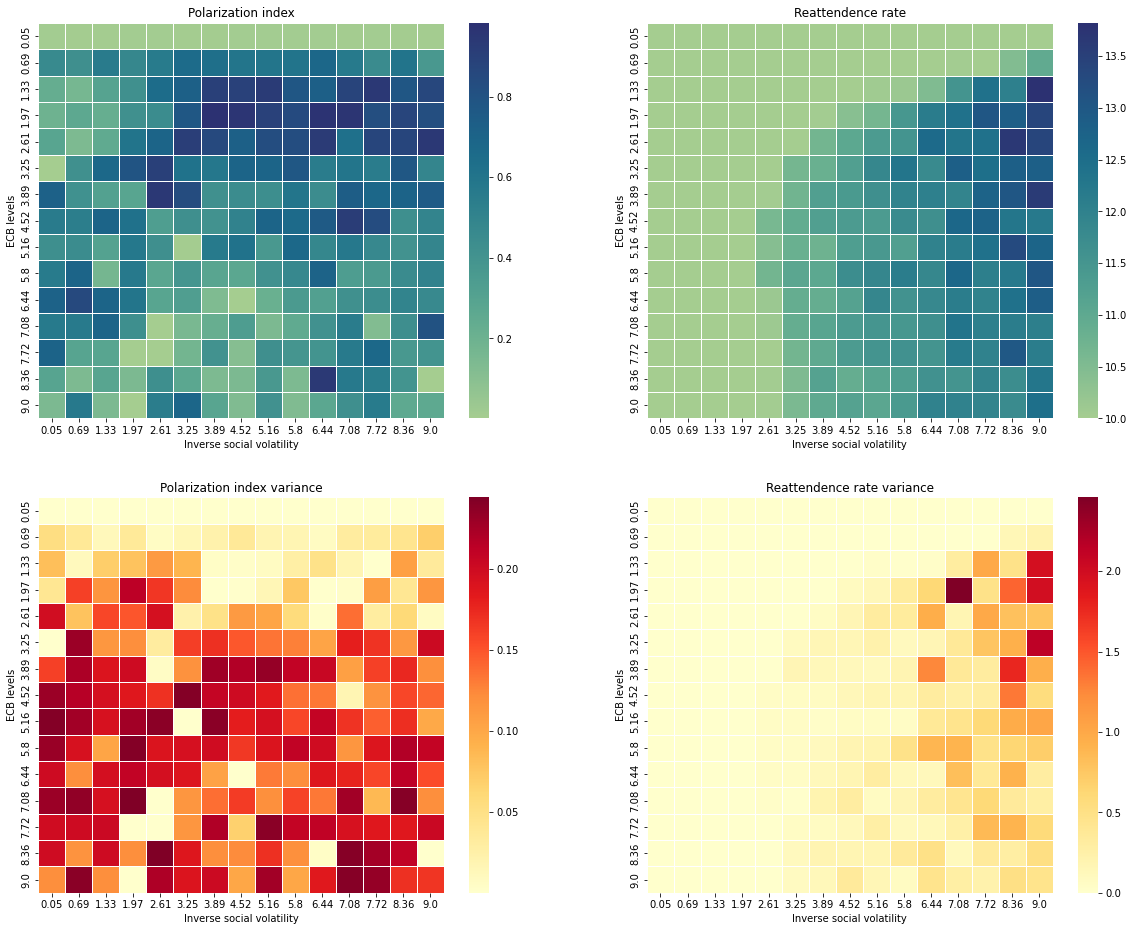

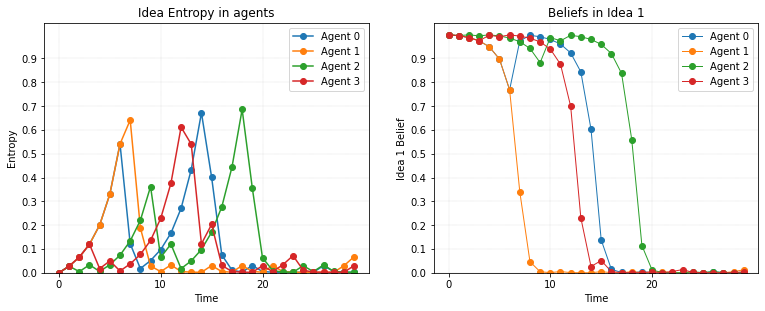

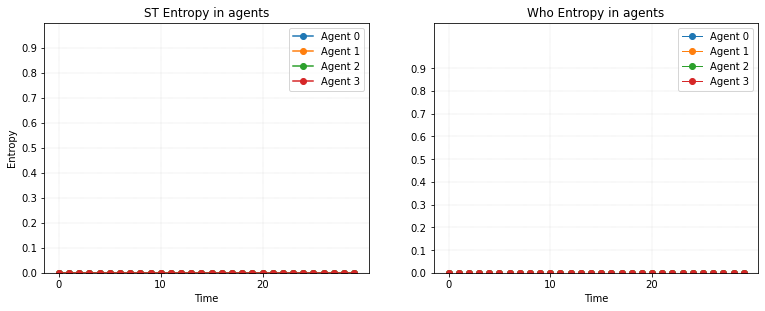

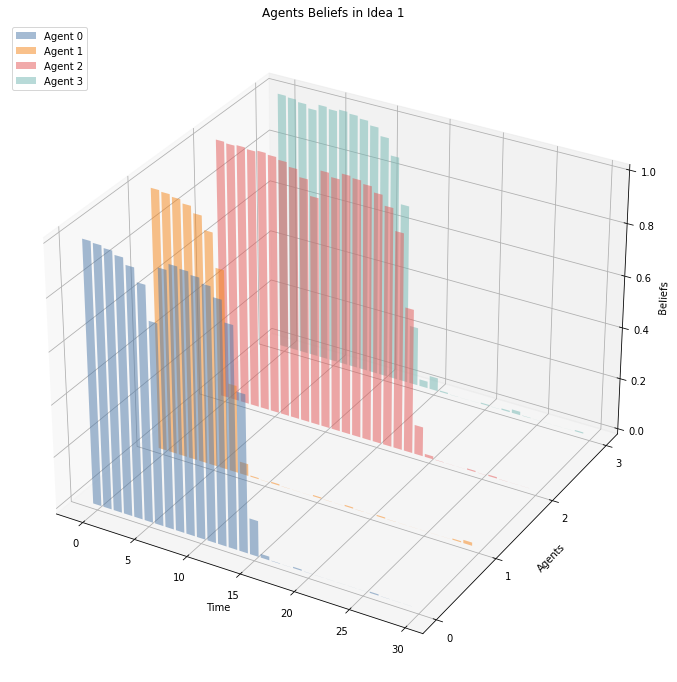

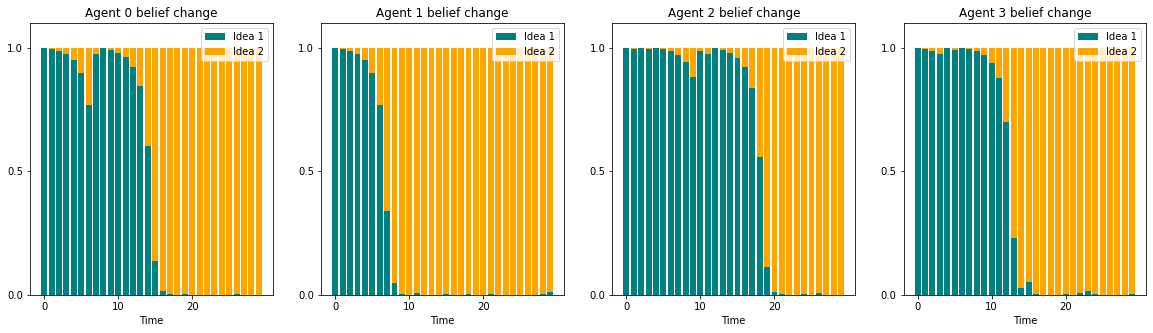

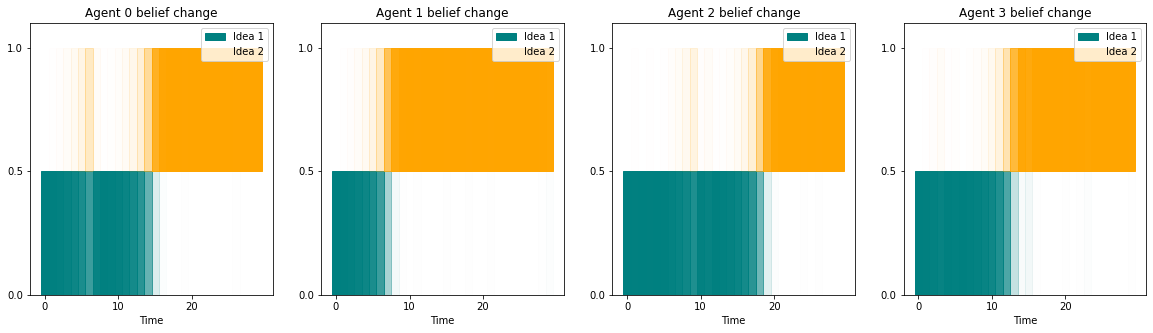

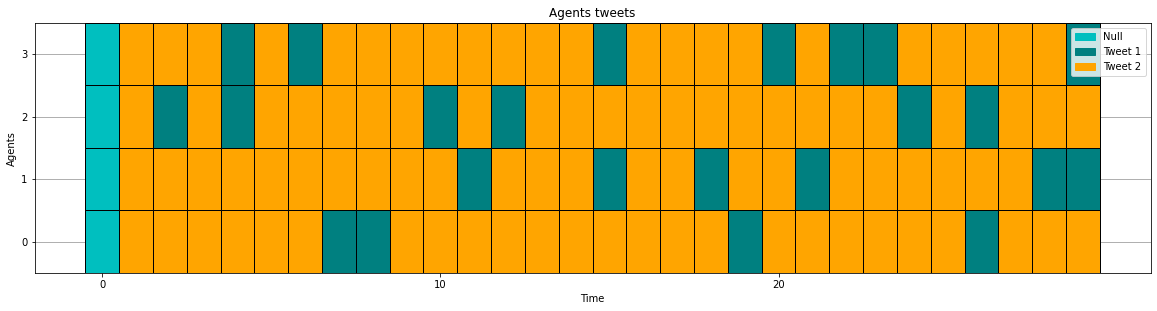

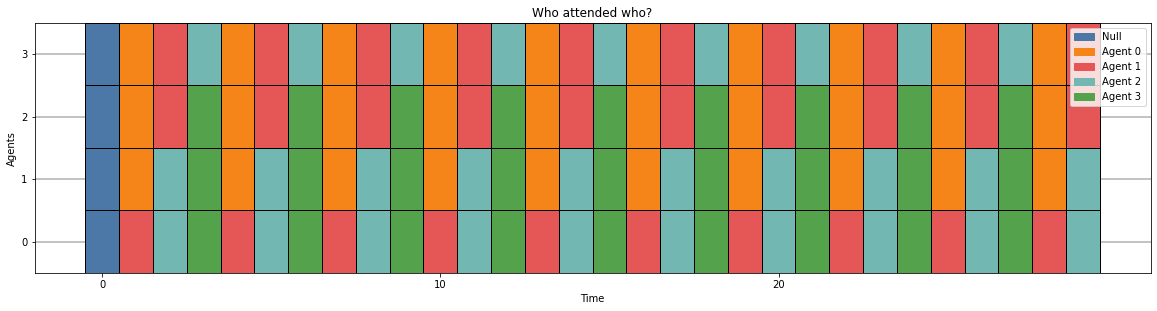

['Null', 'Agent 1', 'Agent 2', 'Agent 3']
['Null', 'Agent 0', 'Agent 2', 'Agent 3']
['Null', 'Agent 0', 'Agent 1', 'Agent 3']
['Null', 'Agent 0', 'Agent 1', 'Agent 2']
[1, 10, 10, 10, 1, 10, 10, 10, 1, 10, 10, 10, 1, 10, 10, 10]


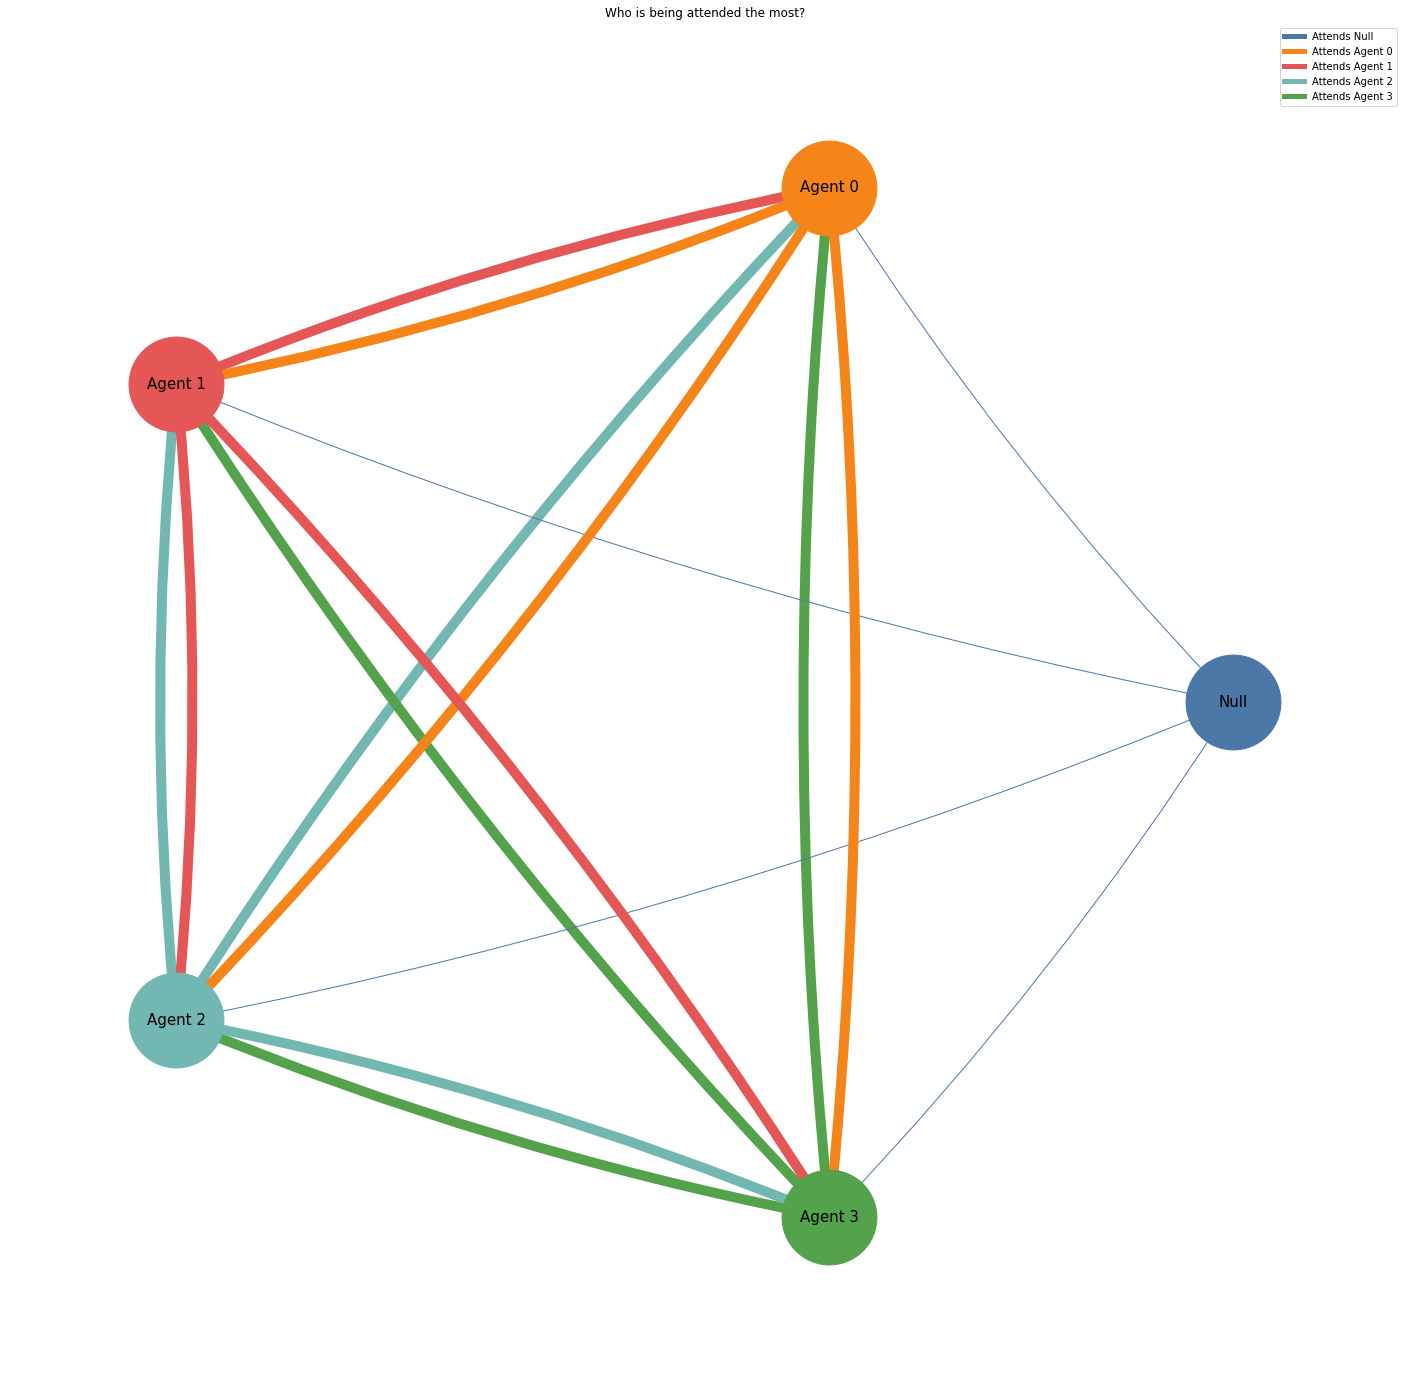

CPU times: total: 4.66 s
Wall time: 5.03 s


In [200]:
%%time
# 15*15 parameter pairs and 7 simulations per pair # flat prefs - prior in wrong context

plot_heatmap(ndata)

#example: show plots for the 6th value of gamma_values and 2nd value of inv_soc_values, in the second simulation of this setting
plot_performance_better(ndata, 5, 1, 1) 